### Step 1 - loading the video data

First load the libraries

In [100]:
#load libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import data,filters
from skimage.measure import compare_ssim as ssim
from sklearn.cluster import KMeans
from collections import Counter

Then import the video as image frames

In [2]:
vs = cv2.VideoCapture("football-video-5-min.mp4")
frames = []
while True:
    (grabbed,tmp) = vs.read()
    frames.append(tmp)
    if not grabbed:
        break

### Step 2 - splitting frames based on similarity

Look at the similarity index between frames to find when the camera angle switches

In [4]:
#get the similarity index for each frame
simIdx = np.zeros(np.shape(frames))
for i in np.arange(np.shape(frames)[0]):
    simIdx[i] = ssim(frames[i+1], frames[i], multichannel=True)
    

Testing frame 0
Testing frame 1
Testing frame 2
Testing frame 3
Testing frame 4
Testing frame 5
Testing frame 6
Testing frame 7
Testing frame 8
Testing frame 9
Testing frame 10
Testing frame 11
Testing frame 12
Testing frame 13
Testing frame 14
Testing frame 15
Testing frame 16
Testing frame 17
Testing frame 18
Testing frame 19
Testing frame 20
Testing frame 21
Testing frame 22
Testing frame 23
Testing frame 24
Testing frame 25
Testing frame 26
Testing frame 27
Testing frame 28
Testing frame 29
Testing frame 30
Testing frame 31
Testing frame 32
Testing frame 33
Testing frame 34
Testing frame 35
Testing frame 36
Testing frame 37
Testing frame 38
Testing frame 39
Testing frame 40
Testing frame 41
Testing frame 42
Testing frame 43
Testing frame 44
Testing frame 45
Testing frame 46
Testing frame 47
Testing frame 48
Testing frame 49
Testing frame 50
Testing frame 51
Testing frame 52
Testing frame 53
Testing frame 54
Testing frame 55
Testing frame 56
Testing frame 57
Testing frame 58
Testing

Testing frame 462
Testing frame 463
Testing frame 464
Testing frame 465
Testing frame 466
Testing frame 467
Testing frame 468
Testing frame 469
Testing frame 470
Testing frame 471
Testing frame 472
Testing frame 473
Testing frame 474
Testing frame 475
Testing frame 476
Testing frame 477
Testing frame 478
Testing frame 479
Testing frame 480
Testing frame 481
Testing frame 482
Testing frame 483
Testing frame 484
Testing frame 485
Testing frame 486
Testing frame 487
Testing frame 488
Testing frame 489
Testing frame 490
Testing frame 491
Testing frame 492
Testing frame 493
Testing frame 494
Testing frame 495
Testing frame 496
Testing frame 497
Testing frame 498
Testing frame 499
Testing frame 500
Testing frame 501
Testing frame 502
Testing frame 503
Testing frame 504
Testing frame 505
Testing frame 506
Testing frame 507
Testing frame 508
Testing frame 509
Testing frame 510
Testing frame 511
Testing frame 512
Testing frame 513
Testing frame 514
Testing frame 515
Testing frame 516
Testing fr

Testing frame 918
Testing frame 919
Testing frame 920
Testing frame 921
Testing frame 922
Testing frame 923
Testing frame 924
Testing frame 925
Testing frame 926
Testing frame 927
Testing frame 928
Testing frame 929
Testing frame 930
Testing frame 931
Testing frame 932
Testing frame 933
Testing frame 934
Testing frame 935
Testing frame 936
Testing frame 937
Testing frame 938
Testing frame 939
Testing frame 940
Testing frame 941
Testing frame 942
Testing frame 943
Testing frame 944
Testing frame 945
Testing frame 946
Testing frame 947
Testing frame 948
Testing frame 949
Testing frame 950
Testing frame 951
Testing frame 952
Testing frame 953
Testing frame 954
Testing frame 955
Testing frame 956
Testing frame 957
Testing frame 958
Testing frame 959
Testing frame 960
Testing frame 961
Testing frame 962
Testing frame 963
Testing frame 964
Testing frame 965
Testing frame 966
Testing frame 967
Testing frame 968
Testing frame 969
Testing frame 970
Testing frame 971
Testing frame 972
Testing fr

Testing frame 1354
Testing frame 1355
Testing frame 1356
Testing frame 1357
Testing frame 1358
Testing frame 1359
Testing frame 1360
Testing frame 1361
Testing frame 1362
Testing frame 1363
Testing frame 1364
Testing frame 1365
Testing frame 1366
Testing frame 1367
Testing frame 1368
Testing frame 1369
Testing frame 1370
Testing frame 1371
Testing frame 1372
Testing frame 1373
Testing frame 1374
Testing frame 1375
Testing frame 1376
Testing frame 1377
Testing frame 1378
Testing frame 1379
Testing frame 1380
Testing frame 1381
Testing frame 1382
Testing frame 1383
Testing frame 1384
Testing frame 1385
Testing frame 1386
Testing frame 1387
Testing frame 1388
Testing frame 1389
Testing frame 1390
Testing frame 1391
Testing frame 1392
Testing frame 1393
Testing frame 1394
Testing frame 1395
Testing frame 1396
Testing frame 1397
Testing frame 1398
Testing frame 1399
Testing frame 1400
Testing frame 1401
Testing frame 1402
Testing frame 1403
Testing frame 1404
Testing frame 1405
Testing fram

AttributeError: 'NoneType' object has no attribute 'shape'

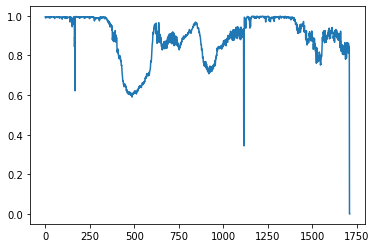

In [49]:
#plot the results    
plt.plot(simIdx)

Check that the similarity index is capturing when the camera angle is changing

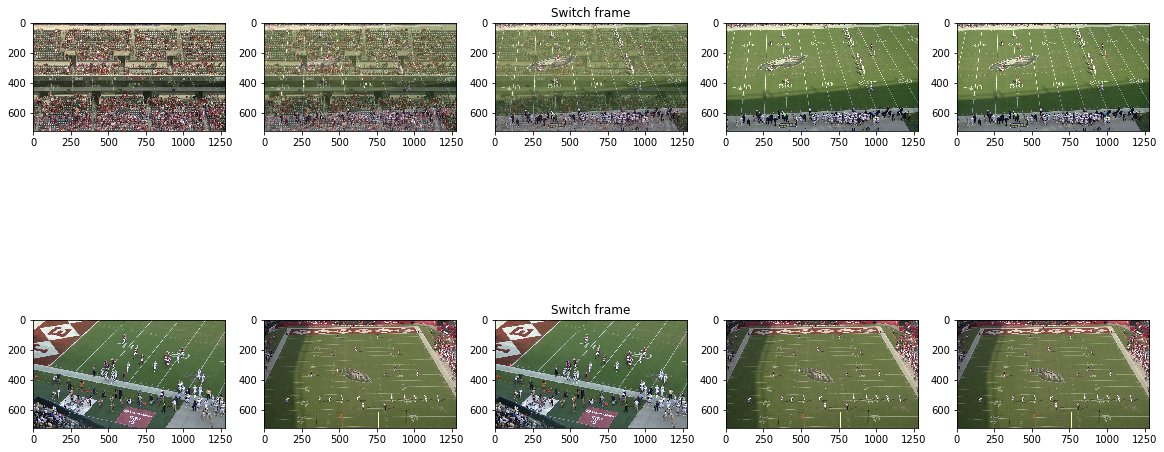

In [83]:
#get indices where the similarity diff is greater than 25%
switchFrames = [i for i, val in enumerate(np.diff(simIdx)>0.25) if val] 

#plot the figures around the switch frames
fig, ax = plt.subplots(np.shape(switchFrames)[0],5, figsize=(20, 10))
for i in np.arange(np.shape(switchFrames)[0]):
    ax[i,0].imshow(cv2.cvtColor(frames[switchFrames[i]-2], cv2.COLOR_BGR2RGB)) #need to switch the color order first
    ax[i,1].imshow(cv2.cvtColor(frames[switchFrames[i]-1], cv2.COLOR_BGR2RGB))
    ax[i,2].imshow(cv2.cvtColor(frames[switchFrames[i]], cv2.COLOR_BGR2RGB))
    ax[i,2].set_title('Switch frame')
    ax[i,3].imshow(cv2.cvtColor(frames[switchFrames[i]+1], cv2.COLOR_BGR2RGB))
    ax[i,4].imshow(cv2.cvtColor(frames[switchFrames[i]+2], cv2.COLOR_BGR2RGB))

We can conclude from this that the frame after the detected switch is the best estimate of when the next play or view angle is starting 

### Step 3 - identifying play start/end times versus camera view angle switch times

First we will get images from the times around the switch frames

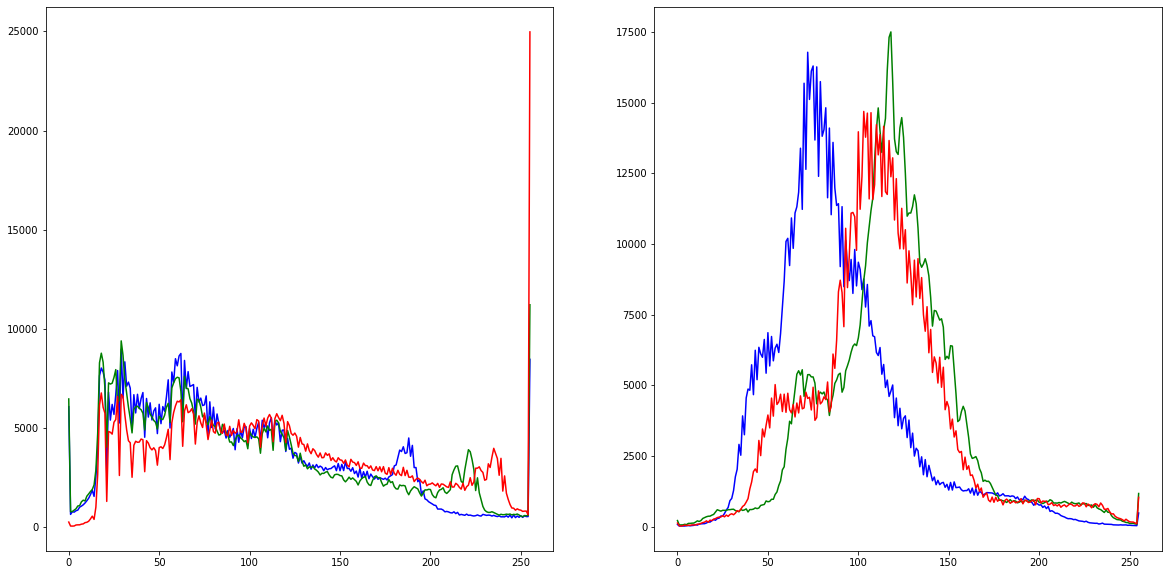

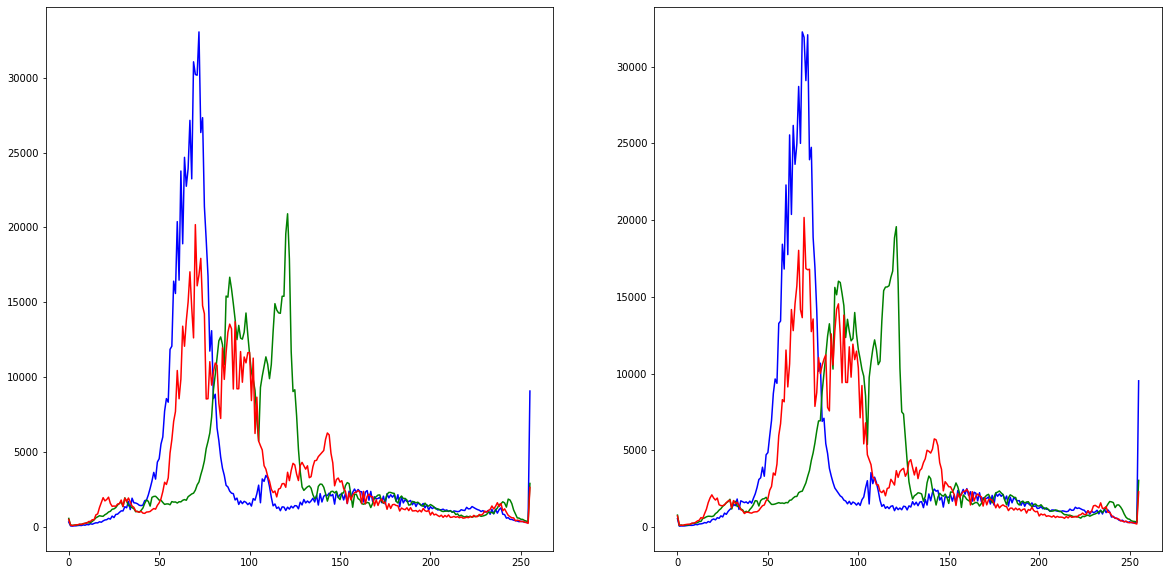

In [130]:
#loop through all of the potential switch frames
framewin = 10
for i in np.arange(np.shape(switchFrames)[0]):
    #get a window of frames around the switch time
    frames_pre_switch = frames[switchFrames[i]-framewin:switchFrames[i]]
    frames_post_switch = frames[switchFrames[i]:switchFrames[i]+framewin]
    
    #get the histograms of color before and after the switch times
    color = ('b','g','r')
    fig, ax = plt.subplots(1,2,figsize=(20, 10))
    for i,col in enumerate(color):
        hist_pre = cv2.calcHist(frames_pre_switch,[i],None,[256],[0,256])
        hist_post = cv2.calcHist(frames_post_switch,[i],None,[256],[0,256])
        ax[0].plot(hist_pre,color = col)
        ax[1].plot(hist_post,color = col)
    plt.show()
